# Linear Regression on Steroids is All You Need

This notebook is support material for the seminar I will be doing for the group.

In [102]:
import os

import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn import datasets
from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt

from interpret.glassbox import  ExplainableBoostingRegressor
from interpret import show

pd.set_option('display.float_format', '{:.3f}'.format)
sns.set()

In [103]:
this_file_path = os.path.dirname(os.path.abspath("__file__"))
PLOTS_PATH = os.path.abspath(os.path.join(this_file_path, '..','figures'))

# Diabetes Progression

We are going to use a simple regression dataset for explaining this seminar. This dataset uses medical and demographic variables from a patient to predict its diabetes progression w.r.t. a baseline. 

In [104]:
diabetes_data = datasets.load_diabetes(scaled=False)
variable_names = ['age', 
                  'sex',
                  'bmi',
                  'average blood pressure',
                  'total serum cholesterol',
                  'low-density lipoproteins',
                  'high-density lipoproteins',
                  'total cholesterol / HDL',
                  'log of serum triglycerides level',
                  'blood sugar level']
diabetes = pd.DataFrame(diabetes_data['data'], columns=variable_names)
diabetes['diabetes'] = diabetes_data['target']

diabetes['sex'] = diabetes['sex'].astype('category')

X = diabetes.iloc[:,:-1]  # variables
y = diabetes['diabetes']  # target

diabetes.describe()

,age,bmi,average blood pressure,total serum cholesterol,low-density lipoproteins,high-density lipoproteins,total cholesterol / HDL,log of serum triglycerides level,blood sugar level,diabetes
count,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000
mean,48.518,26.376,94.647,189.140,115.439,49.788,4.070,4.641,91.260,152.133
std,13.109,4.418,13.831,34.608,30.413,12.934,1.290,0.522,11.496,77.093
min,19.000,18.000,62.000,97.000,41.600,22.000,2.000,3.258,58.000,25.000
25%,38.250,23.200,84.000,164.250,96.050,40.250,3.000,4.277,83.250,87.000
50%,50.000,25.700,93.000,186.000,113.000,48.000,4.000,4.620,91.000,140.500
75%,59.000,29.275,105.000,209.750,134.500,57.750,5.000,4.997,98.000,211.500
max,79.000,42.200,133.000,301.000,242.400,99.000,9.090,6.107,124.000,346.000


In [105]:
diabetes.shape

(442, 11)

In [106]:
diabetes.columns

Index(['age', 'sex', 'bmi', 'average blood pressure',
       'total serum cholesterol', 'low-density lipoproteins',
       'high-density lipoproteins', 'total cholesterol / HDL',
       'log of serum triglycerides level', 'blood sugar level', 'diabetes'],
      dtype='object')

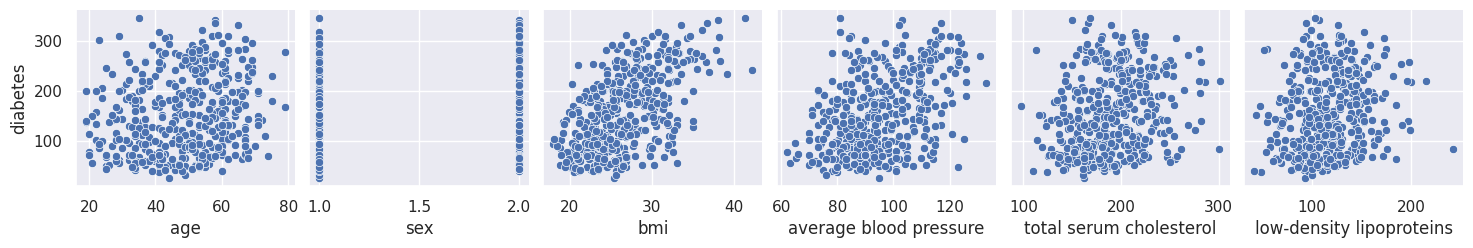

In [107]:
sns.pairplot(diabetes,y_vars=['diabetes'], x_vars = ['age', 'sex', 'bmi', 'average blood pressure',
       'total serum cholesterol', 'low-density lipoproteins']);
plt.savefig(os.path.join(PLOTS_PATH,'diabetes_0.png'))

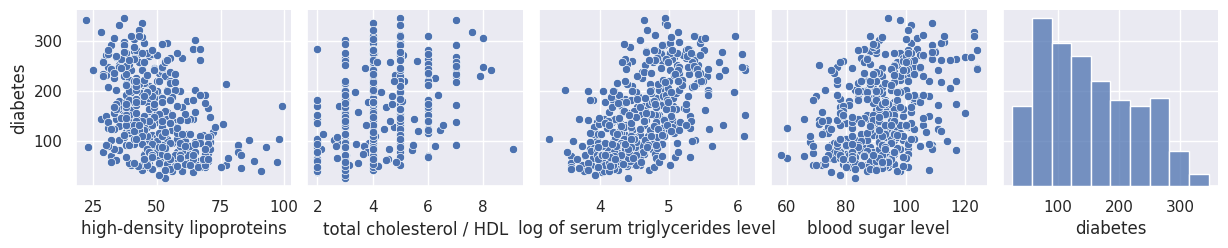

In [108]:
sns.pairplot(diabetes,y_vars=['diabetes'], x_vars = ['high-density lipoproteins', 'total cholesterol / HDL',
       'log of serum triglycerides level', 'blood sugar level', 'diabetes']);
plt.savefig(os.path.join(PLOTS_PATH,'diabetes_1.png'))

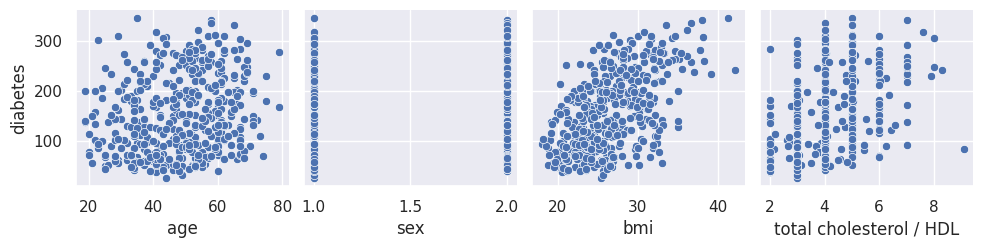

In [109]:
sns.pairplot(diabetes,y_vars=['diabetes'], x_vars = ['age', 'sex', 'bmi', 'total cholesterol / HDL']);
plt.savefig(os.path.join(PLOTS_PATH,'diabetes_2.png'))

# Linear Regression

$y =  \epsilon + w_0x_0 + w_1x_1  +  \dots + w_nx_n $

Linear regression is one of the most simple an explainable models as you can see the effect to the target of modifying each of the variables independently. 

The main problem with this model is that needs to take into account a set of quite restrictive assumptions.
* Target variable is Gaussian.
* Variables do not interact between them. 
* There is a linear relationship between variables and target.

There are several implementations of linear regression. Most used ones are [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) and [statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html) ones.

In [110]:
regressor = LinearRegression()
regressor.fit(X,y)

weights = regressor.coef_
intercept=regressor.intercept_
weights, intercept

(array([-3.63612242e-02, -2.28596481e+01,  5.60296209e+00,  1.11680799e+00,
        -1.08999633e+00,  7.46450456e-01,  3.72004715e-01,  6.53383194e+00,
         6.84831250e+01,  2.80116989e-01]),
 -334.5671385187869)

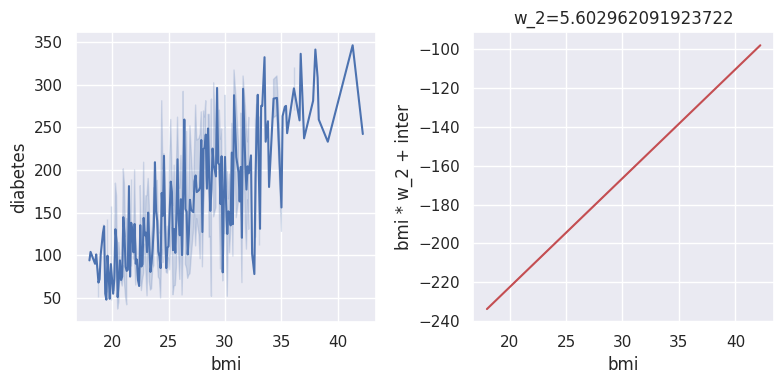

In [111]:
fig, axes = plt.subplots(1,2,figsize=(8,4));
sns.lineplot(x=diabetes['bmi'], y=diabetes['diabetes'],ax=axes[0]);
sns.lineplot(x=diabetes['bmi'], y=diabetes['bmi'] * weights[2]+intercept,color='r',ax=axes[1]);
axes[1].set_ylabel('bmi * w_2 + inter');
axes[1].set_title(f'w_2={weights[2]}')
fig.set_tight_layout('pad')

In [112]:
regressor.score(X,y)

0.5177484222203498

Even though sklearn is really simple to use, statsmodels returns more information that can be helpful for model interpretation. 

Next table shows: 
* coef: The weights computed by the model. It shows how much effect has the variable in the prediction. 
* std err: The standard error of the weights. It shows how much sure the model is about the weight value. 
* t statistic: The feature importance (weight / std_err(weight)). If the error is big, the feature is less important. 
* p value of t statistic: If variable importance shows statistic significance for the model. 
* [0.025      0.975] The confidence intervals of the weights. 

In [113]:
x = sm.add_constant(X)

#fit linear regression model
model = sm.OLS(y, x,).fit()

#view model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               diabetes   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Thu, 22 Sep 2022   Prob (F-statistic):           3.83e-62
Time:                        11:13:34   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

You can also use this library for plotting a partial regression plot. 

This plot shows the relationship between the response and the given explanatory variable after removing the effect of all other explanatory variables.

For doing so, x axis shows the values of the residuals of the prediction of the variable we are checking by using the other variables and y axis the values of the residuals of the original model. 

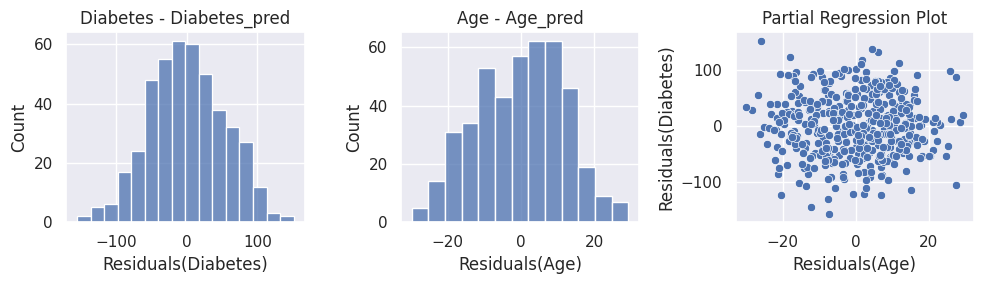

In [114]:
weights = model.params.values
pred =   np.matmul(x.values, weights.T)

residuals = y - pred



age_index = 1

non_age = np.full(x.shape[1], True)
non_age[age_index] = False

age = x.values[:,age_index]
other_variables = x.values[:, non_age]


age_model = sm.OLS(age, other_variables,).fit()
age_residuals = age_model.resid

fig, axes = plt.subplots(1, 3, figsize=(10,3))

sns.histplot(residuals,ax=axes[0]);

axes[0].set_title('Diabetes - Diabetes_pred')
axes[0].set_xlabel('Residuals(Diabetes)')

sns.histplot(age_residuals, ax=axes[1]);
axes[1].set_title('Age - Age_pred')
axes[1].set_xlabel('Residuals(Age)')

sns.scatterplot(y=residuals, x=age_residuals, ax=axes[2]);
axes[2].set_xlabel('Residuals(Age)')
axes[2].set_ylabel('Residuals(Diabetes)')
axes[2].set_title('Partial Regression Plot')

plt.tight_layout()

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


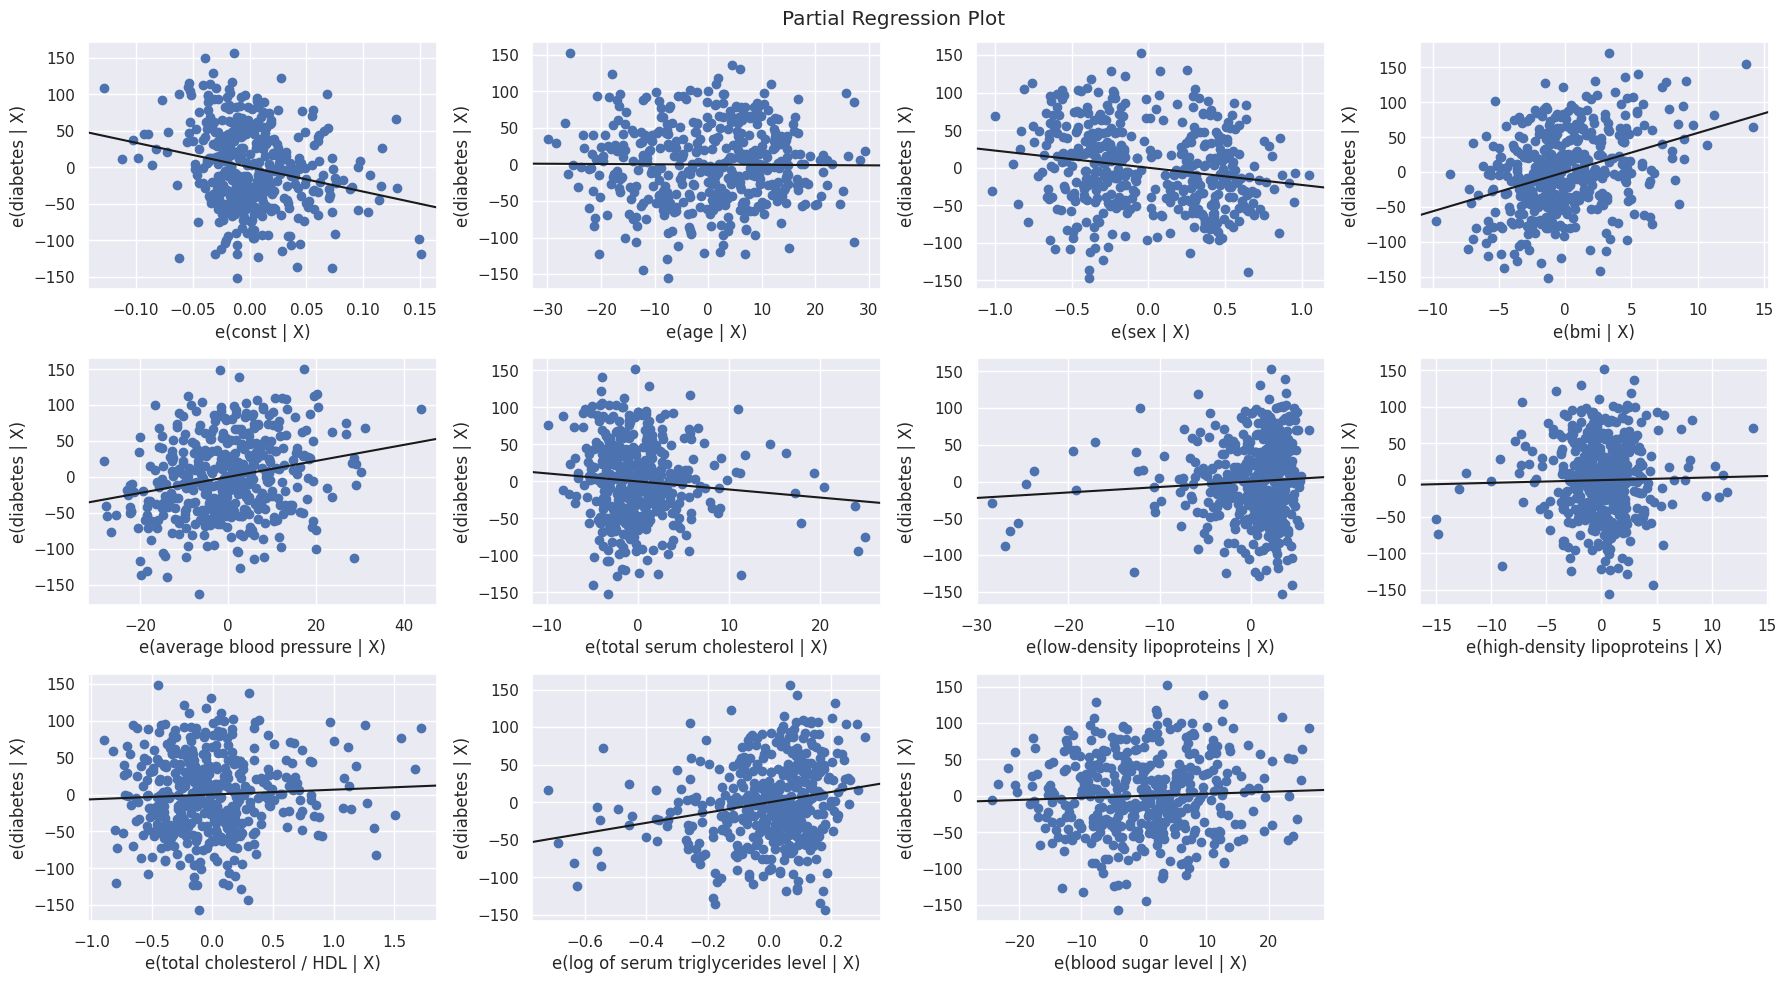

In [115]:
fig = plt.figure(figsize=(18,10));
sm.graphics.plot_partregress_grid(model,grid = (3,4) ,fig=fig);
fig.tight_layout(pad=1.0);

# Explainable Boosting Machine

$g(y) =  \epsilon + \sum f_i(x_i) + \sum f_{i,j}(x_i,x_j)$

EBM are a generalization of the linear regression that instad of using weights, computes a function to estimage which effect should have the variable depending of its value. 

This functions are estimated aggregating a lot of small decision trees. 

<div class="alert alert-warning">
    EBM does not detect data types automatically. You need to pass an array with 'cateogory', 'continuous' or 'interaction'.
</div>

In [116]:
seed = 1

def get_dtypes(data):
    numerical_categorical = list(X.dtypes.map(lambda x: 'categorical' if x=='category' else 'continuous').values)
    interactions = ['interaction']*X.shape[1]
    return numerical_categorical + interactions


ebm = ExplainableBoostingRegressor(random_state=seed,feature_types=get_dtypes(X))

ebm.fit(X, y)
ebm.score(X,y)

0.6673309945556307

In [117]:
ebm_global = ebm.explain_global()
ebm_global.selector

,Name,Type,# Unique,% Non-zero
0,age,continuous,58.000,1.000
1,sex,categorical,2.000,1.000
2,bmi,continuous,163.000,1.000
3,average blood pressure,continuous,100.000,1.000
4,total serum cholesterol,continuous,141.000,1.000
5,low-density lipoproteins,continuous,302.000,1.000
6,high-density lipoproteins,continuous,63.000,1.000
7,total cholesterol / HDL,continuous,66.000,1.000
8,log of serum triglycerides level,continuous,184.000,1.000
9,blood sugar level,continuous,56.000,1.000


<div class="alert alert-warning">
    Plots are done with plotly. For saving them into files you need to install kaleido first. I was not able to install it on windows, but it works properly in a linux based docker. 
</div>

In [118]:
def clean_name(name):
    return name.replace('/','-').strip().replace(' ','_')

for key in range(len(ebm_global.selector)):
    variable = clean_name(ebm_global.selector.loc[key,'Name'])
    fig = ebm_global.visualize(key)
    fig.write_image(os.path.join(PLOTS_PATH,f"global_{variable}.png"))

In [119]:
ebm_local = ebm.explain_local(X[:5], y[:5])
ebm_local.selector

,Predicted,Actual,Resid,AbsResid
0,195.878,151.000,-44.878,44.878
1,75.115,75.000,-0.115,0.115
2,172.481,141.000,-31.481,31.481
3,208.074,206.000,-2.074,2.074
4,106.789,135.000,28.211,28.211


In [120]:
for key in range(len(ebm_local.selector)):
    fig = ebm_local.visualize(key)
    fig.write_image(os.path.join(PLOTS_PATH,f"local_{variable}.png"))

### Complementary readings:
[The Explainable Boosting Machine](https://towardsdatascience.com/the-explainable-boosting-machine-f24152509ebb)

[Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)